<a href="https://colab.research.google.com/github/KAWINYARAVI/Sign_language_recognition/blob/main/Sign_language_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!unzip /content/archive\ \(2\).zip -d /content/sign-language-mnist # Unzip the dataset to a new directory

Archive:  /content/archive (2).zip
  inflating: /content/sign-language-mnist/amer_sign2.png  
  inflating: /content/sign-language-mnist/amer_sign3.png  
  inflating: /content/sign-language-mnist/american_sign_language.PNG  
  inflating: /content/sign-language-mnist/sign_mnist_test.csv  
  inflating: /content/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv  
  inflating: /content/sign-language-mnist/sign_mnist_train.csv  
  inflating: /content/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv  


In [ ]:
import pandas as pd

# Update the file paths to reflect the new location
train_df=pd.read_csv('/content/sign-language-mnist/sign_mnist_train.csv')
test_df=pd.read_csv('/content/sign-language-mnist/sign_mnist_test.csv')

train_images=train_df.drop('label',axis=1).values.reshape((-1,28,28,1))
train_labels=train_df['label'].values

test_images=test_df.drop('label',axis=1).values.reshape((-1,28,28,1))
test_labels=test_df['label'].values
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(27455, 28, 28, 1)
(27455,)
(7172, 28, 28, 1)
(7172,)


Text(0.5, 1.0, 'label: 7  letter: G')

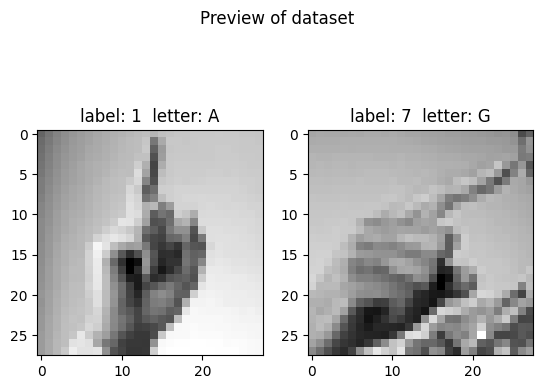

In [ ]:
import matplotlib.pyplot as plt
fig,axe=plt.subplots(1,2)
fig.suptitle('Preview of dataset')
axe[0].imshow(train_images[0].reshape(28,28),cmap='gray')
axe[0].set_title('label: 1  letter: A')
axe[1].imshow(train_images[1].reshape(28,28),cmap='gray')
axe[1].set_title('label: 7  letter: G')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras

train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)
train_generator=train_datagen.flow(
    train_images,
    keras.utils.to_categorical(train_labels,26),
    batch_size=32
)

test_datagen=ImageDataGenerator(
    rescale=1./255,
)
test_generator=test_datagen.flow(
    test_images,
    keras.utils.to_categorical(test_labels,26),
    batch_size=32
)

In [ ]:
import keras

model=keras.Sequential([
    keras.layers.Input(shape=(28,28,1)),
    keras.layers.Conv2D(32,(4,4),activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64,(4,4),activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(256,activation='relu'),
    keras.layers.Dense(26,activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 25, 25, 32)          │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 9, 9, 64)            │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 26)                  │           6,682 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 302,458 (1.15 MB)

 Trainable params: 302,458 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.callbacks import Callback
class call(Callback):
    def on_epoch_end(self,epoch,logs={}):
        if logs.get('val_accuracy')>0.99:
            print('\nReashed +99% val_accuracy')
            self.model.stop_training=True

In [ ]:
history=model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=[call()]
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


858/858 ━━━━━━━━━━━━━━━━━━━━ 37s 40ms/step - accuracy: 0.3424 - loss: 2.1773 - val_accuracy: 0.8522 - val_loss: 0.4390
Epoch 2/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.8161 - loss: 0.5658 - val_accuracy: 0.9384 - val_loss: 0.2015
Epoch 3/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 44s 48ms/step - accuracy: 0.9112 - loss: 0.2822 - val_accuracy: 0.9658 - val_loss: 0.1073
Epoch 4/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 36s 42ms/step - accuracy: 0.9483 - loss: 0.1619 - val_accuracy: 0.9732 - val_loss: 0.0740
Epoch 5/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 35s 41ms/step - accuracy: 0.9655 - loss: 0.1144 - val_accuracy: 0.9707 - val_loss: 0.0686
Epoch 6/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 35s 41ms/step - accuracy: 0.9713 - loss: 0.0925 - val_accuracy: 0.9840 - val_loss: 0.0442
Epoch 7/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.9796 - loss: 0.0645 - val_accuracy: 0.9887 - val_loss: 0.0320
Epoch 8/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9845 - loss: 0.0509
Reashed +99% v

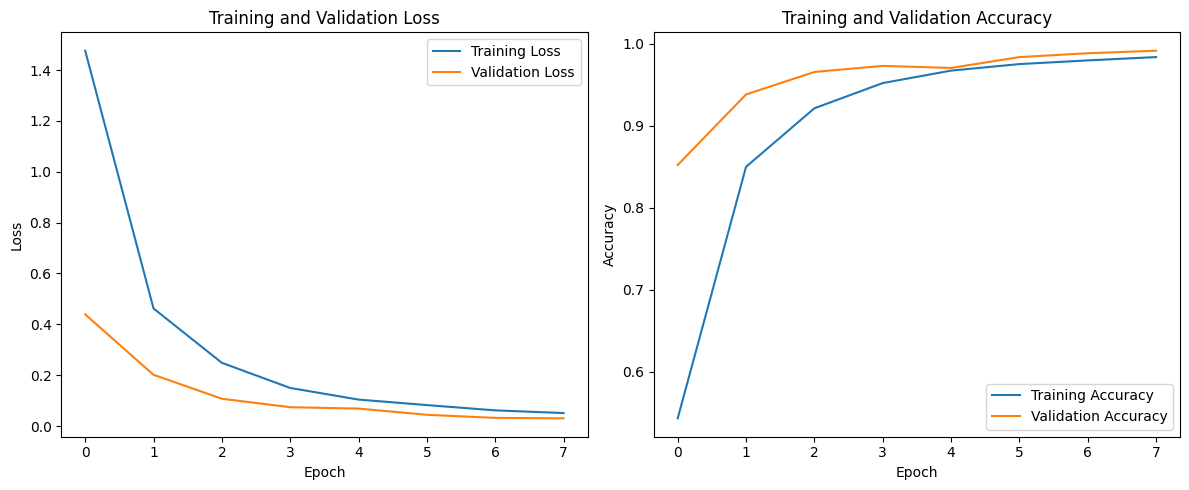

In [ ]:
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()